# Part 2: Loading a saved model

__Before starting, we recommend you enable GPU acceleration if you're running on Colab. You'll also need to upload the weights you downloaded previously using the following block and using the upload button to upload your bettercnn.weights file:__

In [2]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision
    
try: 
    import torchbearer
except:
    !pip install torchbearer

try:
    from google.colab import files
    uploaded = files.upload()
except:
    print("Not running on colab. Ignoring.")

!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/0.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/1.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/2.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/3.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/4.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/5.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/6.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/7.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/8.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/9.PNG

Saving bettercnn.weights to bettercnn.weights
--2020-03-24 15:05:16--  http://comp6248.ecs.soton.ac.uk/labs/lab5/0.PNG
Resolving comp6248.ecs.soton.ac.uk (comp6248.ecs.soton.ac.uk)... 185.199.109.153, 185.199.110.153, 185.199.111.153, ...
Connecting to comp6248.ecs.soton.ac.uk (comp6248.ecs.soton.ac.uk)|185.199.109.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2514 (2.5K) [image/png]
Saving to: ‘0.PNG’

0.PNG               100%[===================>]   2.46K  --.-KB/s    in 0s      

2020-03-24 15:05:16 (527 MB/s) - ‘0.PNG’ saved [2514/2514]

--2020-03-24 15:05:18--  http://comp6248.ecs.soton.ac.uk/labs/lab5/1.PNG
Resolving comp6248.ecs.soton.ac.uk (comp6248.ecs.soton.ac.uk)... 185.199.109.153, 185.199.110.153, 185.199.111.153, ...
Connecting to comp6248.ecs.soton.ac.uk (comp6248.ecs.soton.ac.uk)|185.199.109.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2448 (2.4K) [image/png]
Saving to: ‘1.PNG.1’

1.PNG.1             100%[==

## Reading models and propagating input

At this point, we know how to train a model and how to save the resultant weights. Let's assume we're in the business of building a real system for handwritten character recognition; we need to be able to read in a previously trained model and forward propagate an image from outside the MNIST dataset through it in order to generate a prediction. Let's build some code to do just that. Firstly we need to load the model we saved in the previous part of the lab; PyTorch doesn't save the model structure by default, so you'll need to copy-paste the `BetterCNN` `forward` method implementation from the previous workbook into the block below:

In [5]:
%matplotlib inline
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn

import torch 
import torch.nn.functional as F
from torch import nn

# Model Definition
class BetterCNN(nn.Module):
    
    def __init__(self):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, (5, 5), padding=0)
        self.conv2 = nn.Conv2d(30, 15, (3, 3), padding=0)
        self.fc1 = nn.Linear(15 * 5**2, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, 10)
    
    def forward(self, x):
        # Convolutional layer with 30 feature maps and ReLU activation
        out = self.conv1(x)        
        out = F.relu(out)
        
        # Pooling layer
        out = F.max_pool2d(out, (2,2))
        
        # Convolutiona layer with 15 feature maps and ReLU activation
        out = self.conv2(out)
        out = F.relu(out)
        
        # Pooling layer
        out = F.max_pool2d(out, (2,2))
        
        # Dropout layer with a probability of 0.2(20%)
        out = F.dropout(out, 0.2)
        
        # Flatten layer
        out = out.view(out.shape[0], -1)
          
        # Fully connected layer with 128 neurons and ReLU activation
        out = self.fc1(out)
        out = F.relu(out)
        
        # Fully connected layer with 50 neurons and ReLU activation
        out = self.fc2(out)
        out = F.relu(out)
        
        # Linear output layer
        out = self.fc3(out)
        return out

# build the model and load state
model = BetterCNN()
model.load_state_dict(torch.load('bettercnn.weights'))

# put model in eval mode
model = model.eval() 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We've provided a set of images you can try. Let's load the one corresponding to a '1', convert it to a tensor, and display it:

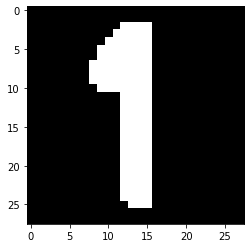

In [21]:
from PIL import Image
import numpy as np
import torchvision

transform = torchvision.transforms.ToTensor()
im = Image.open("{}.PNG".format(1))
im = transform(im)
(r, c) = np.unravel_index(i, (2, 5))
plt.imshow(im[0], cmap=plt.get_cmap('gray'))

Now we'll use the model to make a prediction. The model expects input to have a batch dimension, so we use `unsqueeze(0)` to prepend one to the image. Recall that the model outputs the logits of the classes; the index of the biggest one will tell us which class has been predicted.

In [27]:
batch = im.unsqueeze(0)
predictions = model(batch)

print("logits:", predictions.data)

_, predicted_class = predictions.max(1)

print("predicted class:", predicted_class.item())

logits: tensor([[ -4.7444,   5.1194,  -1.6613, -10.7384,  -1.0629,  -5.0532,   0.2763,
           0.7474,   3.8860,  -4.5760]])
predicted class: 1


We've provided images `0.PNG` through to `9.PNG` for you to play with. Use the following code block to classify each image and print the results.

Actual: 0 | Predicted: 0
Actual: 1 | Predicted: 8
Actual: 2 | Predicted: 2
Actual: 3 | Predicted: 3
Actual: 4 | Predicted: 4
Actual: 5 | Predicted: 5
Actual: 6 | Predicted: 6
Actual: 7 | Predicted: 7
Actual: 8 | Predicted: 8
Actual: 9 | Predicted: 9


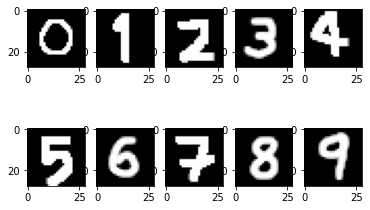

In [29]:
fig, ax = plt.subplots(2, 5)
for i in range(0, 10):
    im = Image.open("{}.PNG".format(i))
    im = transform(im)
    (r, c) = np.unravel_index(i, (2, 5))
    ax[r][c].imshow(im[0], cmap=plt.get_cmap('gray'))
    
    batch = im.unsqueeze(0)
    predictions = model(batch)
    _, predicted_class = predictions.max(1)
    print("Actual: {} | Predicted: {}".format(i, predicted_class.item()))

__Answer the following question (enter the answer in the box below each one):__

__1.__ How many images were missclassified? Which images?



```
# This is formatted as code
```

50% chance of mis-predictiong 1